# Lab-1 (2) Deep Learning: Backpropagation and Network Training
In this lab, we will build a simple fully-connected neural network and train it with backpropagation. After that, we will predict the result of input data using the trained model.

In [74]:
#coding:utf-8
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)

# Exercise 1: Backpropagation for Activation Functions
**1. Backpropagation for Sigmoid:**

The formula of the sigmoid activation function is:

$$
\begin{aligned}
F(x) & =\sigma(x) =\frac{1}{1+e^{-x}}
\end{aligned}
$$

The derivative of the sigmoid function is:

$$
\frac{\partial \sigma(x)}{{\partial x}}=\sigma(x)(1-\sigma(x))
$$

**2. Backpropagation for ReLU:**

The derivative of a ReLU is:
$$
\frac{\partial \operatorname{ReLU}(x)}{\partial x}= \begin{cases}0 & \text { if } x<0 \\ 1 & \text { if } x>0\end{cases}
$$


In [75]:
def sigmoid(input_sum):

    output = 1.0/(1 + np.exp(- input_sum))
    return output, input_sum

def sigmoid_backpropagation(derror_wrt_output, input_sum):

    output = 1.0/(1 + np.exp(- input_sum))

    # Exercise 1
    # YOUR CODE HERE
    doutput_wrt_dinput = output * (1 - output)
    derror_wrt_dinput = derror_wrt_output * doutput_wrt_dinput
    
    return derror_wrt_dinput

In [76]:
def relu(input_sum):

    output = np.maximum(0, input_sum)
    return output, input_sum

def relu_backpropagation(derror_wrt_output, input_sum):

    # Exercise 1
    # YOUR CODE HERE

    derror_wrt_dinputs = np.array(derror_wrt_output)
    derror_wrt_dinputs[input_sum <= 0] = 0
    derror_wrt_dinputs[input_sum > 0] = 1

    return derror_wrt_dinputs

In [77]:
def activated(activation_choose, input):

    if activation_choose == "sigmoid":
        return sigmoid(input)
    elif activation_choose == "relu":
        return relu(input)

    return sigmoid(input)

def activated_backpropagation(activation_choose, derror_wrt_output, output):
    
    if activation_choose == "sigmoid":
        return sigmoid_backpropagation(derror_wrt_output, output)
    elif activation_choose == "relu":
        return relu_backpropagation(derror_wrt_output, output)

# Exercise 2 and 3: Error Calculation and Backpropagation for Cross-Entropy Loss

**The binary cross-entropy loss is:**

$$
\mathcal L=-[\boldsymbol{y} * \log (\widehat{\boldsymbol{y}})+(1-\mathbf{y}) * \log (1-\widehat{\boldsymbol{y}})]
$$

**The gradient wrt $W$:**
$$
\frac{\partial \mathcal L}{\partial W}=\frac{\widehat{\boldsymbol{y}}-\boldsymbol{y}}{\widehat{\boldsymbol{y}}(1-\widehat{\boldsymbol{y}})} \widehat{\boldsymbol{y}}(1-\widehat{\boldsymbol{y}}) \boldsymbol{X}=(\widehat{\boldsymbol{y}}-\boldsymbol{y}) \boldsymbol{X}
$$

# Exercise 4: Gradient Update for W and b

**The rule update to optimize the weight parameter is:**
$$
\begin{aligned}
\Delta_{w} & =\nabla_{w} \mathcal{L} \\
w & :=w-\alpha \Delta_{w}
\end{aligned}
$$

# Exercise 5: Predict Output by the Model After Training

In [83]:
class NeuralNetwork:

    def __init__(self, layers_strcuture, print_cost = False):
        self.layers_strcuture = layers_strcuture
        self.layers_num = len(layers_strcuture)

        self.param_layers_num = self.layers_num - 1 # remove input layer

        self.x = None
        self.y = None
        self.w = dict()
        self.b = dict()
        self.costs = []
        self.print_cost = print_cost

        self.init_w_and_b()

    def set_learning_rate(self, learning_rate):

        self.learning_rate = learning_rate

    def set_num_iterations(self, num_iterations):

        self.num_iterations = num_iterations

    def set_xy(self, input, expected_output):

        self.x = input
        self.y = expected_output

    def init_w_and_b(self):

        np.random.seed(3)

        for l in range(1, self.layers_num):
            self.w["w" + str(l)] = np.random.randn(self.layers_strcuture[l], self.layers_strcuture[l-1])/np.sqrt(self.layers_strcuture[l-1])
            self.b["b" + str(l)] = np.zeros((self.layers_strcuture[l], 1))
        return self.w, self.b

    def layer_activation_forward(self, x, w, b, activation_choose):

        input_sum = np.dot(w, x) + b

        output, _ = activated(activation_choose, input_sum)

        return output, (x, w, b, input_sum)

    def forward_propagation(self, x):
        
        caches = []

        output_prev = x

        # range(1, n) => [1, 2, ..., n-1]
        L = self.param_layers_num
        for l in range(1, L):

            input_cur = output_prev
            output_prev, cache = self.layer_activation_forward(input_cur, self.w["w"+ str(l)], self.b["b" + str(l)], "sigmoid")
            caches.append(cache)

        output, cache = self.layer_activation_forward(output_prev, self.w["w" + str(L)], self.b["b" + str(L)], "sigmoid")
        caches.append(cache)

        return output, caches


    def compute_error(self, output):

        m = self.y.shape[1]

        # Exercise 2
        # YOUR CODE HERE
        # calculate error

        error = -np.sum((self.y * np.log(output)) + ((1 - self.y) * np.log(1 - output)))
        error = np.squeeze(error)
        error = error/m

        return error

    def layer_activation_backward(self, derror_wrt_output, cache, activation_choose):

        input, w, b, input_sum = cache
        output_prev = input     
        m = output_prev.shape[1]     

        derror_wrt_dinput = activated_backpropagation(activation_choose, derror_wrt_output, input_sum)
        derror_wrt_dw = np.dot(derror_wrt_dinput, output_prev.T) / m

        derror_wrt_db = np.sum(derror_wrt_dinput, axis=1, keepdims=True)/m

        derror_wrt_output_prev = np.dot(w.T, derror_wrt_dinput)

        return derror_wrt_output_prev, derror_wrt_dw, derror_wrt_db

    def back_propagation(self, output, caches):

        grads = {}
        L = self.param_layers_num #
        output = output.reshape(output.shape) 

        expected_output = self.y

        # cross-entropy loss
        # Exercise 3
        # YOUR CODE HERE

        derror_wrt_output = -((expected_output / output) - ((1 - expected_output) / (1 - output)))
        
        current_cache = caches[L - 1] 
        grads["derror_wrt_output" + str(L)], grads["derror_wrt_dw" + str(L)], grads["derror_wrt_db" + str(L)] = \
            self.layer_activation_backward(derror_wrt_output, current_cache, "sigmoid")

        for l in reversed(range(L - 1)):
            current_cache = caches[l]
            derror_wrt_output_prev_temp, derror_wrt_dw_temp, derror_wrt_db_temp = \
                self.layer_activation_backward(grads["derror_wrt_output" + str(l + 2)], current_cache, "sigmoid")

            grads["derror_wrt_output" + str(l + 1)] = derror_wrt_output_prev_temp
            grads["derror_wrt_dw" + str(l + 1)] = derror_wrt_dw_temp
            grads["derror_wrt_db" + str(l + 1)] = derror_wrt_db_temp

        return grads

    def update_w_and_b(self, grads):

        for l in range(self.param_layers_num):
            # Exercise 4
            # YOUR CODE HERE
            self.w["w" + str(l + 1)] += (-self.learning_rate * grads["derror_wrt_dw" + str(l + 1)])
            self.b["b" + str(l + 1)] += (-self.learning_rate * grads["derror_wrt_db" + str(l + 1)])

            
    def training_model(self):

        np.random.seed(5)
        for i in range(0, self.num_iterations):
            
            output, caches = self.forward_propagation(self.x)

            cost = self.compute_error(output)

            grads = self.back_propagation(output, caches)

            self.update_w_and_b(grads)

            if self.print_cost and i % 1000 == 0:
                print ("Loss after iteration %i: %f" % (i, cost))
            if self.print_cost and i % 1000 == 0:
                self.costs.append(cost)

        if False:
            plt.plot(np.squeeze(self.costs))
            plt.ylabel('Loss')
            plt.xlabel('Iteration (*100)')
            plt.title("lr =" + str(self.learning_rate))
            plt.show()

        return self.w, self.b

    def predict_by_model(self, x):

        # Exercise 5
        # YOUR CODE HERE
        output, _ = self.forward_propagation(x.T)
        output = output.T
        result = output/np.sum(output, axis=1, keepdims=True)
        
        return np.argmax(result, axis=1)

In [79]:
# plot decision boundary
def plot_decision_boundary(xy, colors, pred_func):

    x_min, x_max = xy[:, 0].min() - 0.5, xy[:, 0].max() + 0.5
    y_min, y_max = xy[:, 1].min() - 0.5, xy[:, 1].max() + 0.5

    h = .01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

    plt.scatter(xy[:, 0], xy[:, 1], c=colors, marker='o', cmap=plt.cm.Spectral, edgecolors='black')

Model training with hidden layer size: 1
Loss after iteration 0: 1.691586
Loss after iteration 1000: 1.182844
Loss after iteration 2000: 1.155515
Loss after iteration 3000: 1.147080
Loss after iteration 4000: 1.142994
Loss after iteration 5000: 1.140548
Loss after iteration 6000: 1.138898
Loss after iteration 7000: 1.137697
Loss after iteration 8000: 1.136776
Loss after iteration 9000: 1.136042
Loss after iteration 10000: 1.135440
Loss after iteration 11000: 1.134935
Loss after iteration 12000: 1.134504
Loss after iteration 13000: 1.134131
Loss after iteration 14000: 1.133803
Loss after iteration 15000: 1.133512
Loss after iteration 16000: 1.133252
Loss after iteration 17000: 1.133017
Loss after iteration 18000: 1.132804
Loss after iteration 19000: 1.132610
Loss after iteration 20000: 1.132432
Loss after iteration 21000: 1.132267
Loss after iteration 22000: 1.132114
Loss after iteration 23000: 1.131973
Loss after iteration 24000: 1.131840
Loss after iteration 25000: 1.131716
Loss after

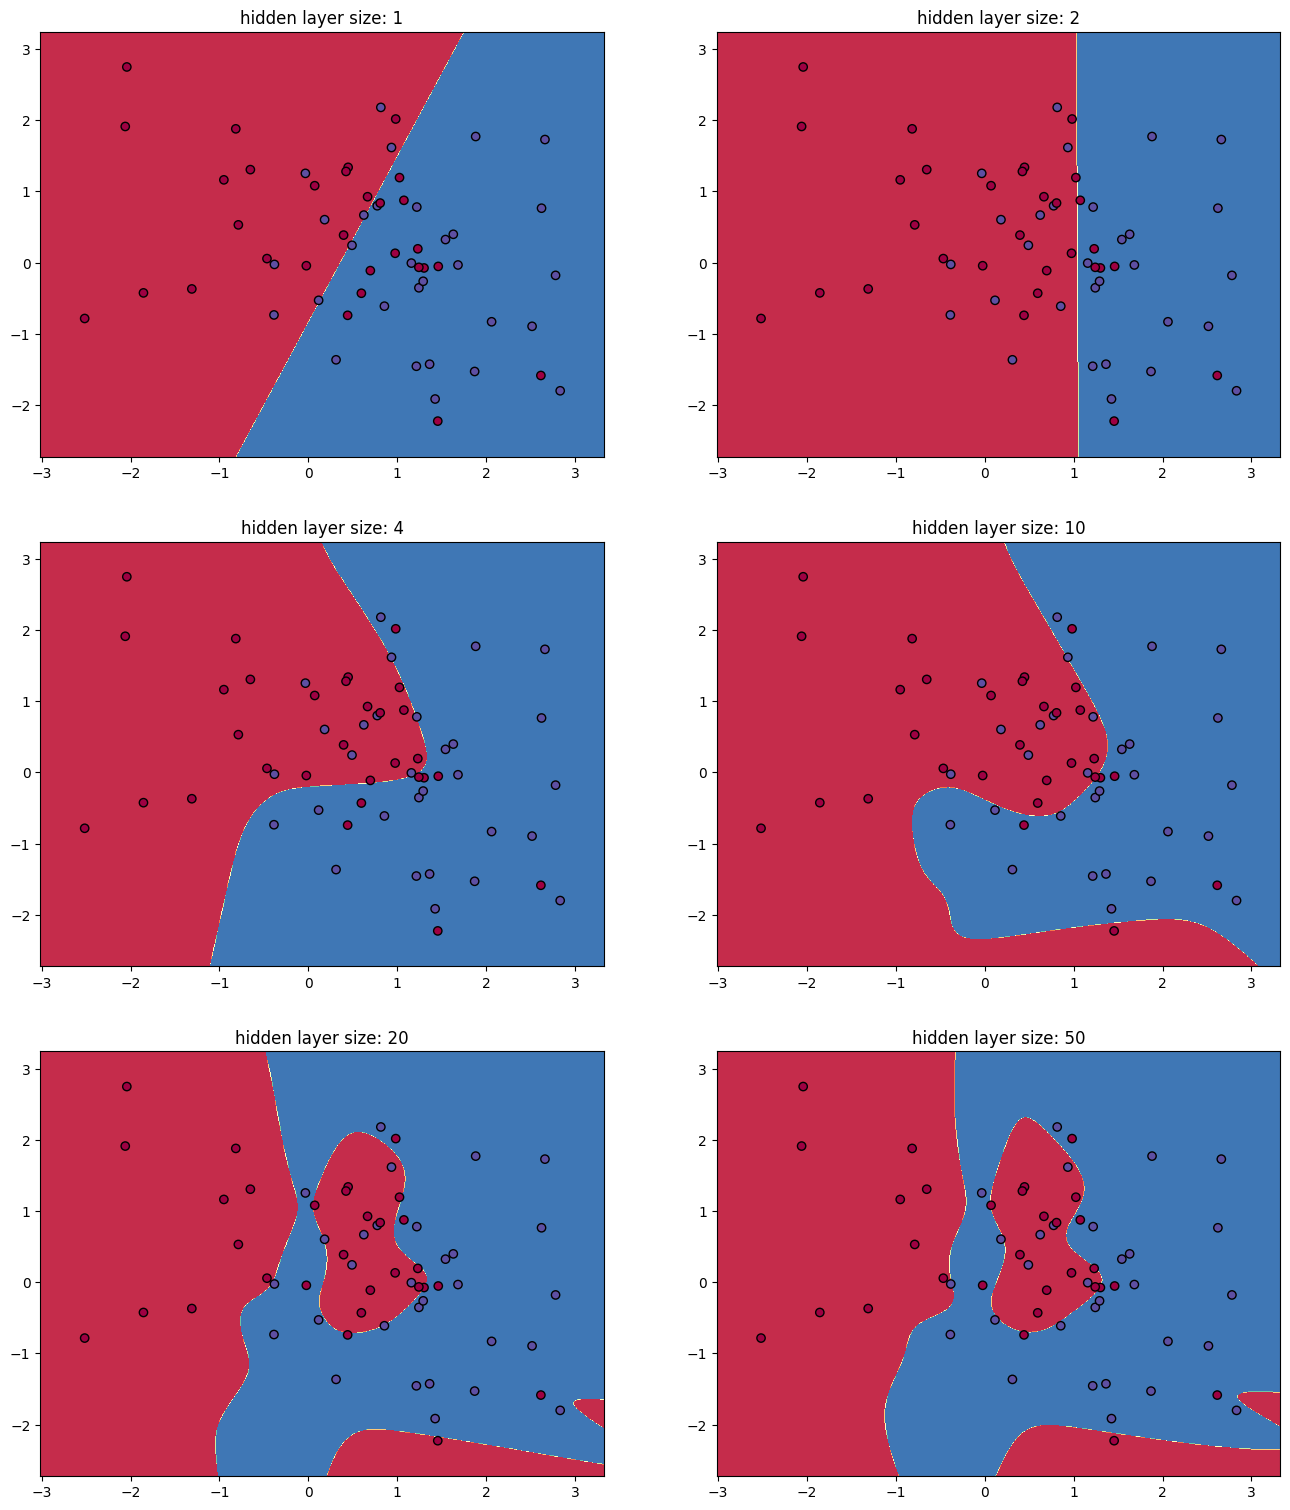

In [84]:
if __name__ == "__main__":
    plt.figure(figsize=(16, 32))

    # load dataset
    xy, colors = sklearn.datasets.make_moons(60, noise=1.0)

    expect_output = []
    for c in colors:
        if c == 1:
            expect_output.append([0,1])
        else:
            expect_output.append([1,0])

    expect_output = np.array(expect_output).T

    hidden_layer_neuron_num_list = [1, 2, 4, 10, 20, 50]

    for i, hidden_layer_neuron_num in enumerate(hidden_layer_neuron_num_list):
        plt.subplot(5, 2, i + 1)
        plt.title('hidden layer size: %d' % hidden_layer_neuron_num)

        nn = NeuralNetwork([2, hidden_layer_neuron_num, 2], True)

        nn.set_xy(xy.T, expect_output)
        nn.set_num_iterations(30000)
        nn.set_learning_rate(0.1)
        print('Model training with hidden layer size: %d' % hidden_layer_neuron_num)
        w, b = nn.training_model()
        plot_decision_boundary(xy, colors, nn.predict_by_model)

    plt.show()